## Visualizing results of the Third Edition -  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the books of the **Third Edition ** of the Encyclopaedia Britannica. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_third_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_third_edition -n 16`


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [5]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [6]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        if place_name not in filter_list:
            print(i, place_count,place_name)
            place_label.append(place_name)
            place_freq.append(place_count)
            k = k + 1
        i = i + 1
    return place_label, place_freq

In [7]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq, color = 'green')
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')
    plt.savefig('SpaCy3rdEdition.png', dpi=300)

### Information about the defoe georesolution query

This query does the following tasks:

- Ingests all the pages from all the books of the first edition
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_doc: HTML string with the name entities detected by spacy for each page
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. 
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (e.g. en_core_web_lg)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


In [8]:
results=read_query_results('georesolution_en_core_web_lg_EB_third_edition')

In [9]:
#display_spacy_entities(results)

In [10]:
df_total= geresolution_dataframe(results)

In [11]:
df_total.head(10)

,Latitude,Longitude,Place,Page
0,55.95206,-3.19648,EDINBURGH,Page11
1,48.69096,9.14062,Europe,Page14
2,47.36293,9.28283,AR,Page14
3,34.23314,-102.41075,earth,Page15
4,39,22,Greece,Page16
5,34.23314,-102.41075,earth,Page16
6,35.83007,-90.28399,vail,Page16
7,34.01778,-118.49912,MONSOON,Page19
8,37.17526,-113.28995,HURRICANE,Page19
9,55.95206,-3.19648,Edinburgh,Page22


In [12]:
df_total[["Place"]].count()

Place    16912
dtype: int64

In [13]:
df_total.sum()

Latitude     55.9520648.6909647.3629334.233143934.2331435.8...
Longitude    -3.196489.140629.28283-102.4107522-102.41075-9...
Place        EDINBURGHEuropeARearthGreeceearthvailMONSOONHU...
Page         Page11Page14Page14Page15Page16Page16Page16Page...
dtype: object

In [14]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
1747,1,1,1
AB,1,1,1
ACAPULCO,1,1,1
AGADES,1,1,1
ANGLESEY,1,1,1
ANGOLA,1,1,1
AO a,1,1,1
APB,1,1,1
AR,3,3,3


In [15]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page10,73,73,73
Page100,22,22,22
Page101,14,14,14
Page102,11,11,11
Page104,16,16,16
Page105,19,19,19
Page106,12,12,12
Page11,107,107,107
Page117,16,16,16


In [16]:
df_total.groupby(["Latitude", "Longitude"]).count()

,,Place,Page
Latitude,Longitude,,
-0.08333,-78.5,1,1
-0.22985,-78.52495,5,5
-0.25,-79.13333,1,1
-0.61667,116.73333,1,1
-0.65668,35.60355,1,1
-0.88333,19.05,1,1
-1.2,127.61667,1,1
-1.25,-78.25,2,2
-1.28333,9.2,1,1


In [17]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     


df_max_geolocations=df_filter
# getting the 10 GEOLOCATIONS more repeated
df_max_geolocations.head(15)

,Latitude,Longitude,count
2805,52.16045,-0.70312,691
1820,41.89193,12.51133,586
866,34.23314,-102.41075,492
3039,56,-4,477
2709,51.50853,-0.12574,471
2306,46,2,470
2466,48.69096,9.14062,362
1977,42.83333,12.83333,287
3036,55.95206,-3.19648,274
2995,54.75844,-2.69531,248


In [18]:
#Getting the 15 places (and their frequencies) most mentioned - filtering out some elements
filter_list=['']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)

0 691 England
1 586 Rome
2 492 earth
3 477 Scotland
4 471 London
5 470 France
6 362 Europe
7 287 Italy
8 274 EDINBURGH
9 248 Britain
10 246 Egypt
11 203 Ireland
12 200 Paris
13 178 Spain
14 170 China


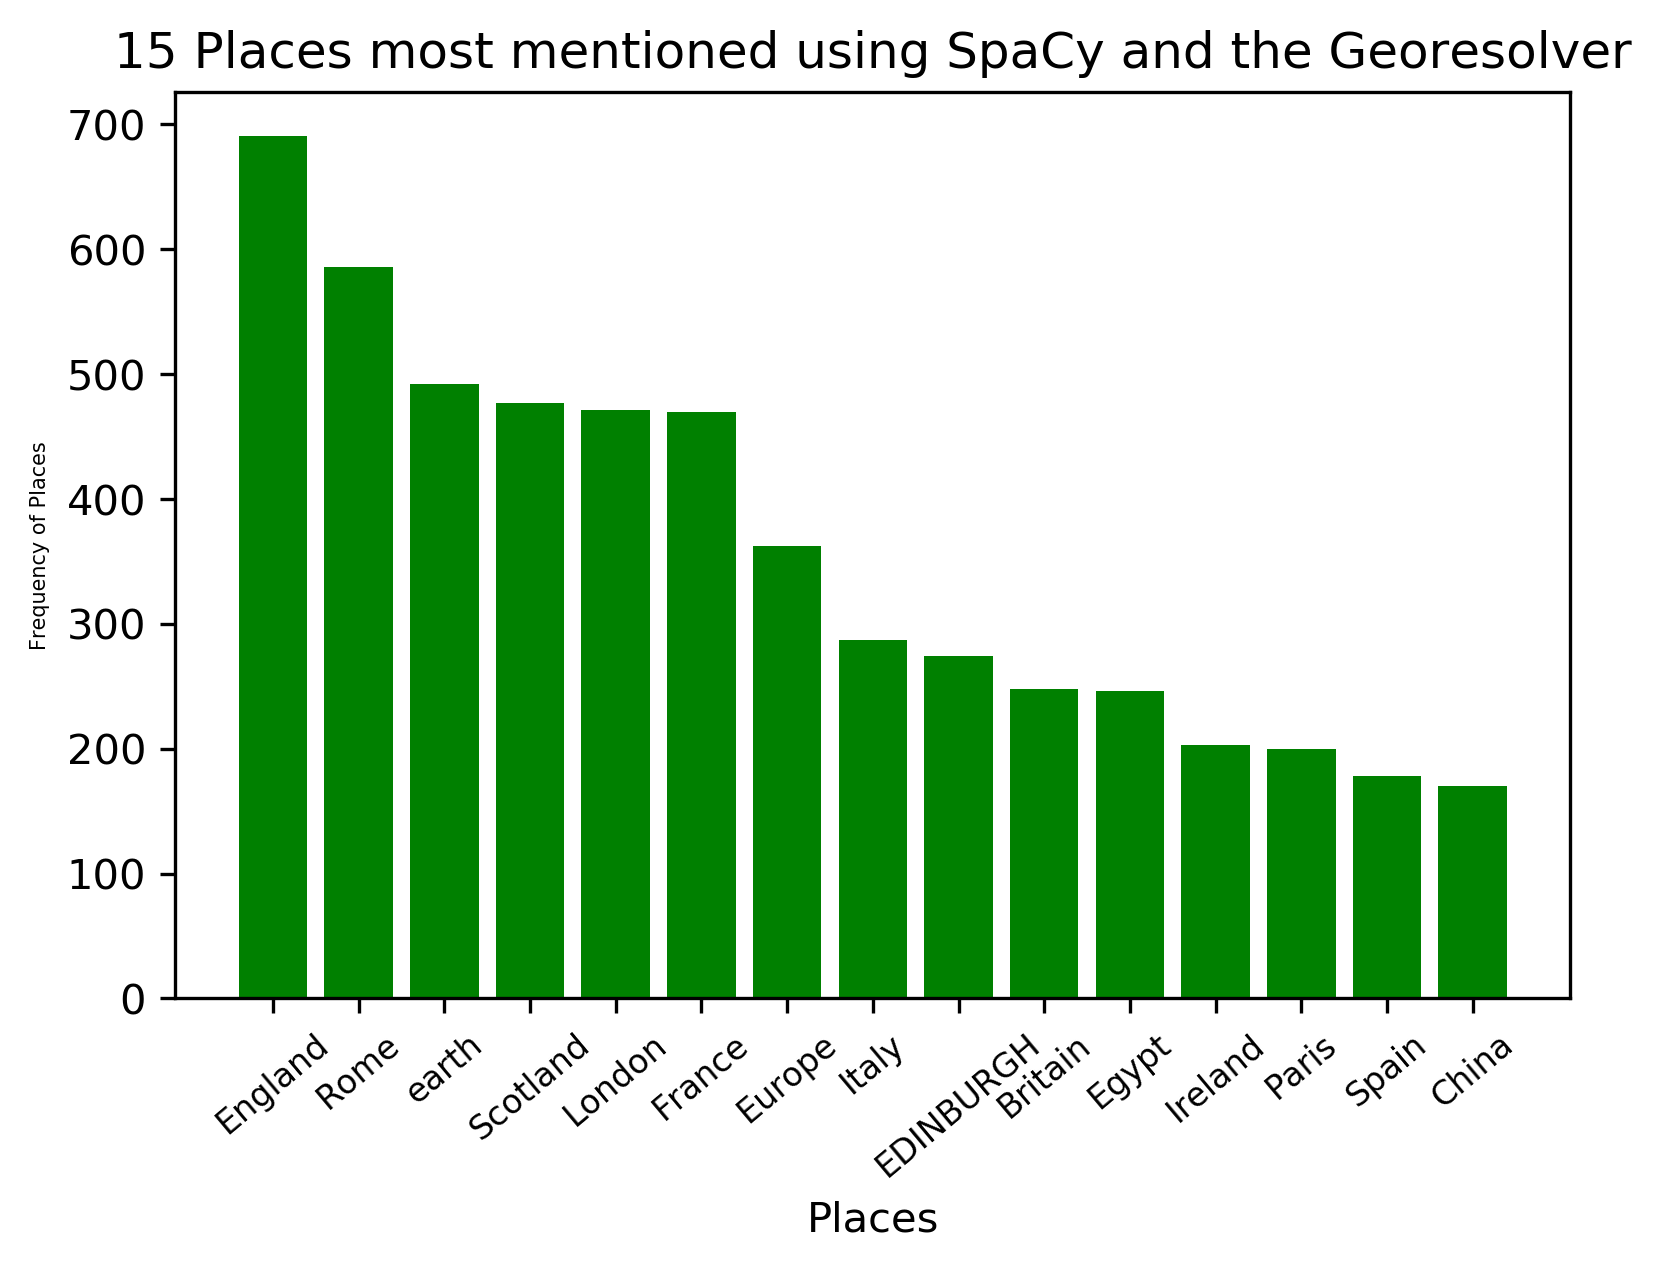

In [19]:
#Visualizing the 15 places in a Bar plot
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq)